In [2]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/input/flipercorrectorvlg/pytorch/default/1/rotnet_model(1).pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

Processing on: cuda
Found 11706 frames to process.


Cleaning: 100%|██████████| 11706/11706 [03:28<00:00, 56.24it/s]

------------------------------
Cleaning Complete!
Total Images: 11706
Images Flipped/Fixed: 1195
Cleaned dataset saved to: /kaggle/working/cleaned_testing_videos


In [8]:
import cv2
import os
import glob
from tqdm import tqdm

# ================= CONFIGURATION =================
# Point this to the folder containing '01', '02', etc.
# Based on your screenshot, it ends in 'testing_videos'
dataset_root = r"/kaggle/working/training_optical_flow"


# Where to save the output MP4 files
output_folder = "rendered_videos"

# Frame rate (Frames Per Second). 
# 25 or 30 is standard. Lower it (e.g., 10) if the video feels too fast.
fps = 25 
# =================================================

def create_video_from_frames(video_folder_path, output_path, fps):
    # 1. Find all images (jpg, png, jpeg)
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        images.extend(glob.glob(os.path.join(video_folder_path, ext)))
    
    if not images:
        print(f"No images found in {video_folder_path}")
        return

    # 2. Sort them numerically! 
    # Standard sort usually fails on "frame_1" vs "frame_10", 
    # but your data has padding (0093), so standard sort usually works.
    # We use a lambda just to be safe.
    try:
        images.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    except:
        images.sort() # Fallback if naming convention is different

    # 3. Read the first frame to get dimensions
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape
    size = (width, height)

    # 4. Initialize VideoWriter
    # 'mp4v' is a standard codec for .mp4
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    # 5. Write frames
    video_name = os.path.basename(output_path)
    for image_path in tqdm(images, desc=f"Rendering {video_name}", unit="frame"):
        img = cv2.imread(image_path)
        out.write(img)

    out.release()
    print(f"Saved: {output_path}")

def main():
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get list of video directories (01, 02, etc.)
    # We assume directories inside 'testing_videos' are the video clips
    video_dirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
    video_dirs.sort()

    print(f"Found {len(video_dirs)} video folders. Starting conversion...")

    for video_dir in video_dirs:
        full_path = os.path.join(dataset_root, video_dir)
        save_path = os.path.join(output_folder, f"video_{video_dir}.mp4")
        
        create_video_from_frames(full_path, save_path, fps)

    print("\nDone! Check the 'rendered_videos' folder.")

if __name__ == "__main__":
    main()

Found 16 video folders. Starting conversion...


Rendering video_01.mp4: 100%|██████████| 644/644 [00:01<00:00, 436.64frame/s]


Saved: rendered_videos/video_01.mp4


Rendering video_02.mp4: 100%|██████████| 789/789 [00:01<00:00, 405.75frame/s]


Saved: rendered_videos/video_02.mp4


Rendering video_03.mp4: 100%|██████████| 776/776 [00:01<00:00, 428.95frame/s]


Saved: rendered_videos/video_03.mp4


Rendering video_04.mp4: 100%|██████████| 492/492 [00:01<00:00, 419.24frame/s]


Saved: rendered_videos/video_04.mp4


Rendering video_05.mp4: 100%|██████████| 705/705 [00:01<00:00, 412.47frame/s]


Saved: rendered_videos/video_05.mp4


Rendering video_06.mp4: 100%|██████████| 717/717 [00:01<00:00, 409.01frame/s]


Saved: rendered_videos/video_06.mp4


Rendering video_07.mp4: 100%|██████████| 491/491 [00:01<00:00, 430.66frame/s]


Saved: rendered_videos/video_07.mp4


Rendering video_08.mp4: 100%|██████████| 840/840 [00:01<00:00, 420.09frame/s]


Saved: rendered_videos/video_08.mp4


Rendering video_09.mp4: 100%|██████████| 711/711 [00:01<00:00, 409.89frame/s]


Saved: rendered_videos/video_09.mp4


Rendering video_10.mp4: 100%|██████████| 734/734 [00:01<00:00, 427.24frame/s]


Saved: rendered_videos/video_10.mp4


Rendering video_11.mp4: 100%|██████████| 761/761 [00:01<00:00, 430.03frame/s]


Saved: rendered_videos/video_11.mp4


Rendering video_12.mp4: 100%|██████████| 145/145 [00:00<00:00, 413.89frame/s]


Saved: rendered_videos/video_12.mp4


Rendering video_13.mp4: 100%|██████████| 339/339 [00:00<00:00, 378.60frame/s]


Saved: rendered_videos/video_13.mp4


Rendering video_14.mp4: 100%|██████████| 488/488 [00:01<00:00, 428.95frame/s]


Saved: rendered_videos/video_14.mp4


Rendering video_15.mp4: 100%|██████████| 344/344 [00:00<00:00, 415.56frame/s]


Saved: rendered_videos/video_15.mp4


Rendering video_16.mp4: 100%|██████████| 228/228 [00:00<00:00, 418.27frame/s]

Saved: rendered_videos/video_16.mp4

Done! Check the 'rendered_videos' folder.


In [4]:
# 1. Clone the Repo
!git clone https://github.com/m-tassano/fastdvdnet.git
%cd fastdvdnet

# 2. Install Dependencies (Kaggle usually has these, but just in case)
!pip install -q torch torchvision opencv-python

# 3. Download Pre-trained Weights (Model.pth)
# We use the 'denoising' weights trained on high noise
!mkdir -p model
!wget -O model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth

fatal: destination path 'fastdvdnet' already exists and is not an empty directory.
/kaggle/working/fastdvdnet
--2026-01-01 10:32:36--  https://github.com/m-tassano/fastdvdnet/raw/master/model.pth
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth [following]
--2026-01-01 10:32:36--  https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9971551 (9.5M) [application/octet-stream]
Saving to: ‘model/model.pth’

model/model.pth     100%[===================>]   9.51M  --.-KB/s    in 0.09s   

2026-01-01

In [5]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_train"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

🛠️ Cloning FastDVDnet...


Cloning into 'fastdvdnet'...


--2026-01-01 10:32:44--  https://github.com/m-tassano/fastdvdnet/raw/master/model.pth
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth [following]
--2026-01-01 10:32:45--  https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9971551 (9.5M) [application/octet-stream]
Saving to: ‘fastdvdnet/model/model.pth’

     0K .......... .......... .......... .......... ..........  0% 4.07M 2s
    50K .......... .......... .......... .......... ..........  1% 5.10M 2s
   100K .......... .......... ........

🌍 Found 16 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 41/41 [00:36<00:00,  1.13it/s]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 53/53 [00:45<00:00,  1.16it/s]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:41<00:00,  1.12it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 48/48 [00:42<00:00,  1.13it/s]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 22/22 [00:20<00:00,  1.10it/s]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset_train


In [6]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/working/cleaned_testing_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

🌍 Found 21 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 76/76 [01:04<00:00,  1.18it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 60/60 [00:51<00:00,  1.16it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 40/40 [00:34<00:00,  1.15it/s]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 37/37 [00:32<00:00,  1.15it/s]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 23/23 [00:20<00:00,  1.10it/s]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:39<00:00,  1.16it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 30/30 [00:26<00:00,  1.13it/s]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 46/46 [00:40<00:00,  1.13it/s]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 33/33 [00:29<00:00,  1.11it/s]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:27<00:00,  1.11it/s]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 46/46 [00:40<00:00,  1.15it/s]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]



🎬 Processing Video: 17


Cleaning 17: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]



🎬 Processing Video: 18


Cleaning 18: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]



🎬 Processing Video: 19


Cleaning 19: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]



🎬 Processing Video: 20


Cleaning 20: 100%|██████████| 18/18 [00:16<00:00,  1.06it/s]



🎬 Processing Video: 21


Cleaning 21: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset


In [7]:
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm

# CONFIG
# Use your Neural Cleaned videos for best flow calculation
SOURCE_DIR = '/kaggle/working/denoised_dataset_train'
DEST_DIR = '/kaggle/working/training_optical_flow'

def extract_optical_flow():
    if not os.path.exists(DEST_DIR): os.makedirs(DEST_DIR)
    
    print("Generating Optical Flow Maps...")
    
    for vid in tqdm(sorted(os.listdir(SOURCE_DIR))):
        vid_path = os.path.join(SOURCE_DIR, vid)
        save_path = os.path.join(DEST_DIR, vid)
        if not os.path.isdir(vid_path): continue
        os.makedirs(save_path, exist_ok=True)
        
        frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        prev_frame = cv2.imread(frames[0])
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        
        # Save first flow as black (no motion) to keep frame count same
        h, w = prev_gray.shape
        blank_flow = np.zeros((h, w, 3), dtype=np.uint8)
        cv2.imwrite(os.path.join(save_path, os.path.basename(frames[0])), blank_flow)
        
        for i in range(1, len(frames)):
            curr_frame = cv2.imread(frames[i])
            curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
            
            # Calculate Dense Optical Flow (Farneback)
            flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 
                                                0.5, 3, 15, 3, 5, 1.2, 0)
            
            # Visualize Flow as RGB Image
            # Magnitude and Angle
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
            # HSV encoding
            hsv = np.zeros_like(prev_frame)
            hsv[..., 1] = 255
            # Hue = Angle, Value = Magnitude (Speed)
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            
            # Convert to RGB for saving
            rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            
            cv2.imwrite(os.path.join(save_path, os.path.basename(frames[i])), rgb_flow)
            
            prev_gray = curr_gray

if __name__ == "__main__":
    extract_optical_flow()

Generating Optical Flow Maps...


100%|██████████| 16/16 [10:57<00:00, 41.09s/it]


In [9]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
# INPUTS
RGB_DIR = '/kaggle/working/denoised_dataset_train'
FLOW_DIR = '/kaggle/working/training_optical_flow'

# OUTPUTS
MODEL_SAVE_PATH = 'joint_resnet_generator.pth'
DISC_SAVE_PATH = 'joint_resnet_discriminator.pth'

# HYPERPARAMETERS (Optimized for Speed)
BATCH_SIZE = 48      # Increased from 4 -> 32 (Should fit in 16GB)
EPOCHS = 30
LR = 2e-4
LR_STEP = 10         # Slightly relaxed decay since we do fewer steps per epoch now
LR_GAMMA = 0.1
T_STEPS = 4
IMG_SIZE = 256

# LOSS WEIGHTS
LAMBDA_INT = 2.0
LAMBDA_GD = 1.0
LAMBDA_ADV = 0.05

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. MODEL ARCHITECTURE ---
class ResidualBlock(nn.Module):
    def __init__(self, channels=512):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn1 = nn.BatchNorm2d(channels); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))) + x)

class ResNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super(ResNetEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 64, 7, 1, 3), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.bottleneck = nn.Sequential(*[ResidualBlock(512) for _ in range(9)])
    def forward(self, x):
        return self.bottleneck(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

class JointRepresentationModel(nn.Module):
    def __init__(self):
        super(JointRepresentationModel, self).__init__()
        self.spatial_encoder = ResNetEncoder(in_channels=12)
        self.temporal_encoder = ResNetEncoder(in_channels=3)
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 3, 2, 1, output_padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(64, 3, 7, 1, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb, flow):
        fused = torch.cat([self.spatial_encoder(rgb), self.temporal_encoder(flow)], dim=1)
        return self.sigmoid(self.final(self.dec3(self.dec2(self.dec1(fused)))))

class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        def d_block(in_c, out_c, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if bn: layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(*d_block(3, 64, bn=False), *d_block(64, 128), *d_block(128, 256), nn.Conv2d(256, 1, 4, 1, 1))
    def forward(self, x): return self.model(x)

# --- 2. LOSS FUNCTIONS ---
def gradient_loss(gen, gt):
    def grad(x): return torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]), torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])
    gen_dx, gen_dy = grad(gen); gt_dx, gt_dy = grad(gt)
    return torch.mean(torch.abs(gen_dx - gt_dx)) + torch.mean(torch.abs(gen_dy - gt_dy))

def intensity_loss(gen, gt): return nn.MSELoss()(gen, gt)

# --- 3. DATASET ---
class JointDataset(Dataset):
    def __init__(self, rgb_dir, flow_dir, transform=None, t_steps=4):
        self.samples = []
        self.transform = transform
        videos = sorted(os.listdir(rgb_dir))
        for vid in videos:
            rgb_p = os.path.join(rgb_dir, vid); flow_p = os.path.join(flow_dir, vid)
            if not os.path.isdir(rgb_p): continue
            frames = sorted(glob.glob(os.path.join(rgb_p, '*.jpg')))
            if len(frames) < t_steps + 1: continue
            for i in range(len(frames) - t_steps):
                self.samples.append((frames[i:i+t_steps], os.path.join(flow_p, os.path.basename(frames[i+t_steps-1])), frames[i+t_steps]))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        rgb_ps, flow_p, tgt_p = self.samples[idx]
        rgb = [Image.open(p).convert('RGB') for p in rgb_ps]
        flow = Image.open(flow_p).convert('RGB')
        tgt = Image.open(tgt_p).convert('RGB')
        if self.transform:
            rgb = [self.transform(i) for i in rgb]; flow = self.transform(flow); tgt = self.transform(tgt)
        return torch.cat(rgb, dim=0), flow, tgt

# --- 4. TRAINING LOOP ---
def train():
    print(f"Initializing FAST Joint ResNet (Batch={BATCH_SIZE}) on {DEVICE}...")
    
    tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
    dataset = JointDataset(RGB_DIR, FLOW_DIR, transform=tf, t_steps=T_STEPS)
    
    # Num workers 8 to prevent CPU bottleneck at Batch 32
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)
    
    gen = JointRepresentationModel().to(DEVICE)
    disc = PatchGANDiscriminator().to(DEVICE)
    if torch.cuda.device_count() > 1: gen = nn.DataParallel(gen); disc = nn.DataParallel(disc)
        
    opt_g = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_d = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))
    
    sched_g = optim.lr_scheduler.StepLR(opt_g, step_size=LR_STEP, gamma=LR_GAMMA)
    sched_d = optim.lr_scheduler.StepLR(opt_d, step_size=LR_STEP, gamma=LR_GAMMA)
    
    mse = nn.MSELoss()
    
    try:
        for epoch in range(EPOCHS):
            gen.train(); disc.train()
            loop = tqdm(loader, desc=f"Ep {epoch+1}/{EPOCHS}")
            
            run_g = 0.0; run_int = 0.0; run_gd = 0.0; run_adv = 0.0; run_d = 0.0
            
            for rgb, flow, target in loop:
                rgb, flow, target = rgb.to(DEVICE), flow.to(DEVICE), target.to(DEVICE)
                
                # --- G Step ---
                opt_g.zero_grad()
                fake = gen(rgb, flow)
                
                pred_fake = disc(fake)
                l_adv = mse(pred_fake, torch.ones_like(pred_fake))
                l_int = intensity_loss(fake, target)
                l_gd = gradient_loss(fake, target)
                
                l_g = (LAMBDA_INT * l_int) + (LAMBDA_GD * l_gd) + (LAMBDA_ADV * l_adv)
                l_g.backward()
                opt_g.step()
                
                # --- D Step ---
                opt_d.zero_grad()
                pred_real = disc(target)
                l_d_real = mse(pred_real, torch.ones_like(pred_real))
                pred_fake_d = disc(fake.detach())
                l_d_fake = mse(pred_fake_d, torch.zeros_like(pred_fake_d))
                l_d = 0.5 * (l_d_real + l_d_fake)
                l_d.backward()
                opt_d.step()
                
                run_g += l_g.item(); run_int += l_int.item(); run_gd += l_gd.item(); run_adv += l_adv.item(); run_d += l_d.item()
                loop.set_postfix(G=l_g.item(), D=l_d.item())
            
            count = len(loader)
            print(f"\n[Ep {epoch+1}] G: {run _g/count:.4f} (Int:{run_int/count:.4f} Gd:{run_gd/count:.4f} Adv:{run_adv/count:.4f}) | D: {run_d/count:.4f} | LR: {sched_g.get_last_lr()[0]:.2e}")
            
            sched_g.step(); sched_d.step()
            
            if (epoch+1) % 5 == 0:
                torch.save(gen.module.state_dict() if hasattr(gen,'module') else gen.state_dict(), f"joint_resnet_ep{epoch+1}.pth")

    except KeyboardInterrupt:
        print("\n[!] Interrupted. Saving...")
        
    torch.save(gen.module.state_dict() if hasattr(gen,'module') else gen.state_dict(), MODEL_SAVE_PATH)
    torch.save(disc.module.state_dict() if hasattr(disc,'module') else disc.state_dict(), DISC_SAVE_PATH)
    print("Done.")

if __name__ == "__main__":
    train()

Initializing FAST Joint ResNet (Batch=48) on cuda...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Ep 1/30: 100%|██████████| 191/191 [08:54<00:00,  2.80s/it, D=0.251, G=0.0396]



[Ep 1] G: 0.0669 (Int:0.0076 Gd:0.0356 Adv:0.3216) | D: 0.2599 | LR: 2.00e-04


Ep 2/30: 100%|██████████| 191/191 [08:51<00:00,  2.78s/it, D=0.253, G=0.033] 



[Ep 2] G: 0.0360 (Int:0.0011 Gd:0.0208 Adv:0.2565) | D: 0.2544 | LR: 2.00e-04


Ep 3/30: 100%|██████████| 191/191 [08:50<00:00,  2.78s/it, D=0.252, G=0.0275]



[Ep 3] G: 0.0300 (Int:0.0007 Gd:0.0160 Adv:0.2515) | D: 0.2530 | LR: 2.00e-04


Ep 4/30: 100%|██████████| 191/191 [08:51<00:00,  2.78s/it, D=0.254, G=0.0329]



[Ep 4] G: 0.0270 (Int:0.0005 Gd:0.0134 Adv:0.2525) | D: 0.2525 | LR: 2.00e-04


Ep 5/30: 100%|██████████| 191/191 [08:50<00:00,  2.78s/it, D=0.253, G=0.0244]



[Ep 5] G: 0.0255 (Int:0.0004 Gd:0.0120 Adv:0.2526) | D: 0.2524 | LR: 2.00e-04


Ep 6/30: 100%|██████████| 191/191 [08:51<00:00,  2.78s/it, D=0.253, G=0.0251]



[Ep 6] G: 0.0243 (Int:0.0003 Gd:0.0110 Adv:0.2524) | D: 0.2521 | LR: 2.00e-04


Ep 7/30: 100%|██████████| 191/191 [08:50<00:00,  2.78s/it, D=0.251, G=0.0231]



[Ep 7] G: 0.0236 (Int:0.0003 Gd:0.0103 Adv:0.2527) | D: 0.2521 | LR: 2.00e-04


Ep 8/30: 100%|██████████| 191/191 [08:50<00:00,  2.78s/it, D=0.253, G=0.0242]



[Ep 8] G: 0.0232 (Int:0.0003 Gd:0.0100 Adv:0.2521) | D: 0.2515 | LR: 2.00e-04


Ep 9/30: 100%|██████████| 191/191 [08:49<00:00,  2.77s/it, D=0.242, G=0.0462]



[Ep 9] G: 0.0594 (Int:0.0067 Gd:0.0290 Adv:0.3414) | D: 0.3073 | LR: 2.00e-04


Ep 10/30: 100%|██████████| 191/191 [08:49<00:00,  2.77s/it, D=0.252, G=0.0351]



[Ep 10] G: 0.0393 (Int:0.0015 Gd:0.0231 Adv:0.2642) | D: 0.2484 | LR: 2.00e-04


Ep 11/30: 100%|██████████| 191/191 [08:49<00:00,  2.77s/it, D=0.25, G=0.0308] 



[Ep 11] G: 0.0315 (Int:0.0007 Gd:0.0175 Adv:0.2526) | D: 0.2500 | LR: 2.00e-05


Ep 12/30: 100%|██████████| 191/191 [08:47<00:00,  2.76s/it, D=0.251, G=0.03]  



[Ep 12] G: 0.0304 (Int:0.0006 Gd:0.0166 Adv:0.2519) | D: 0.2501 | LR: 2.00e-05


Ep 13/30: 100%|██████████| 191/191 [08:50<00:00,  2.78s/it, D=0.25, G=0.029]  



[Ep 13] G: 0.0294 (Int:0.0005 Gd:0.0158 Adv:0.2516) | D: 0.2502 | LR: 2.00e-05


Ep 14/30: 100%|██████████| 191/191 [08:48<00:00,  2.77s/it, D=0.25, G=0.0287] 



[Ep 14] G: 0.0286 (Int:0.0005 Gd:0.0150 Adv:0.2514) | D: 0.2503 | LR: 2.00e-05


Ep 15/30: 100%|██████████| 191/191 [08:48<00:00,  2.77s/it, D=0.25, G=0.0286] 



[Ep 15] G: 0.0278 (Int:0.0004 Gd:0.0144 Adv:0.2512) | D: 0.2504 | LR: 2.00e-05


Ep 16/30:  48%|████▊     | 92/191 [04:22<04:42,  2.85s/it, D=0.25, G=0.0275] 



[!] Interrupted. Saving...
Done.


In [11]:
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm

# CONFIG
# Use your Neural Cleaned videos for best flow calculation
SOURCE_DIR = '/kaggle/working/denoised_dataset'
DEST_DIR = '/kaggle/working/testing_optical_flow'

def extract_optical_flow():
    if not os.path.exists(DEST_DIR): os.makedirs(DEST_DIR)
    
    print("Generating Optical Flow Maps...")
    
    for vid in tqdm(sorted(os.listdir(SOURCE_DIR))):
        vid_path = os.path.join(SOURCE_DIR, vid)
        save_path = os.path.join(DEST_DIR, vid)
        if not os.path.isdir(vid_path): continue
        os.makedirs(save_path, exist_ok=True)
        
        frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        prev_frame = cv2.imread(frames[0])
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        
        # Save first flow as black (no motion) to keep frame count same
        h, w = prev_gray.shape
        blank_flow = np.zeros((h, w, 3), dtype=np.uint8)
        cv2.imwrite(os.path.join(save_path, os.path.basename(frames[0])), blank_flow)
        
        for i in range(1, len(frames)):
            curr_frame = cv2.imread(frames[i])
            curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
            
            # Calculate Dense Optical Flow (Farneback)
            flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 
                                                0.5, 3, 15, 3, 5, 1.2, 0)
            
            # Visualize Flow as RGB Image
            # Magnitude and Angle
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
            # HSV encoding
            hsv = np.zeros_like(prev_frame)
            hsv[..., 1] = 255
            # Hue = Angle, Value = Magnitude (Speed)
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            
            # Convert to RGB for saving
            rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            
            cv2.imwrite(os.path.join(save_path, os.path.basename(frames[i])), rgb_flow)
            
            prev_gray = curr_gray

if __name__ == "__main__":
    extract_optical_flow()

Generating Optical Flow Maps...


100%|██████████| 21/21 [13:54<00:00, 39.72s/it]


🎬 Processing Joint Representation Visualization for Video 10...
🏃 Running dual-stream inference...


100%|██████████| 718/718 [00:49<00:00, 14.62it/s]


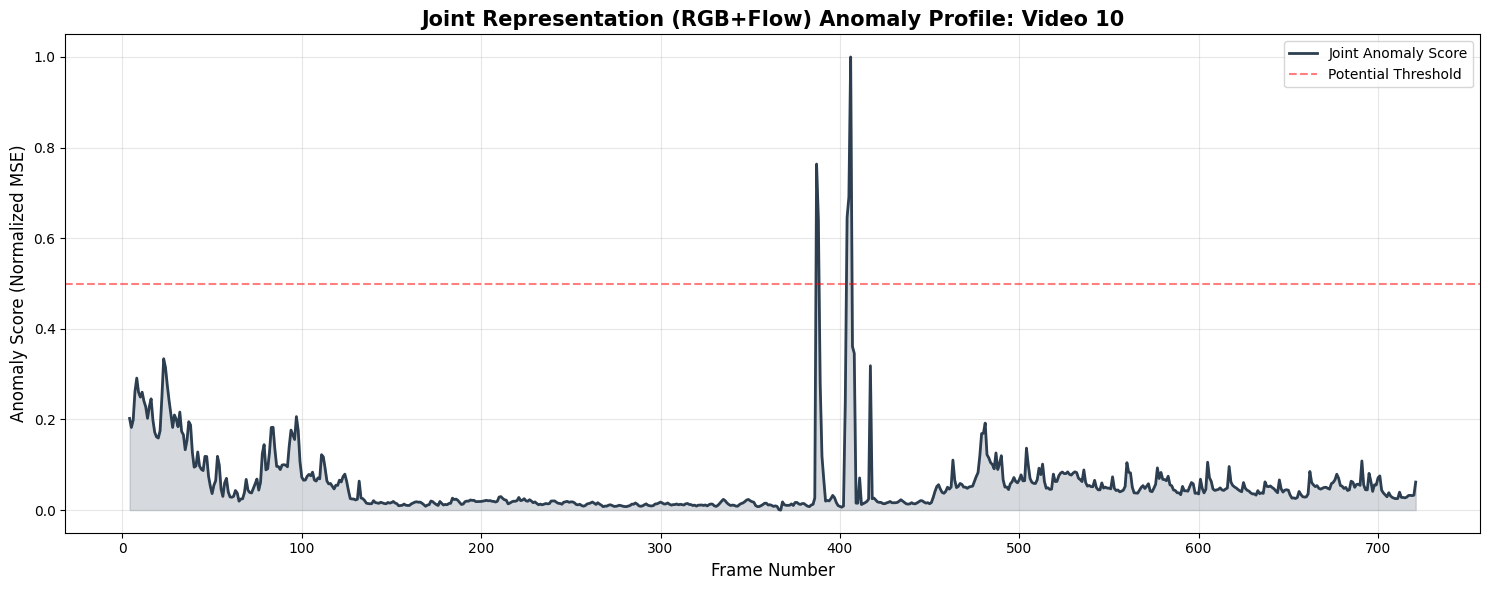

In [13]:
import os
import glob
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Paths to CLEANED TEST data
RGB_TEST_DIR = '/kaggle/working/denoised_dataset' 
FLOW_TEST_DIR = '/kaggle/working/testing_optical_flow'

# 2. Path to your saved JOINT model
MODEL_PATH = 'joint_resnet_generator.pth'

TARGET_VIDEO = '10' # Change to any video ID like '02', '03'...
IMG_SIZE = 256
T_STEPS = 4 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. ARCHITECTURE RE-DEFINITION ---
# (Must match your training script exactly)
class ResidualBlock(nn.Module):
    def __init__(self, channels=512):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn1 = nn.BatchNorm2d(channels); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))) + x)

class ResNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super(ResNetEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 64, 7, 1, 3), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.bottleneck = nn.Sequential(*[ResidualBlock(512) for _ in range(9)])
    def forward(self, x):
        return self.bottleneck(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

class JointRepresentationModel(nn.Module):
    def __init__(self):
        super(JointRepresentationModel, self).__init__()
        self.spatial_encoder = ResNetEncoder(in_channels=12)
        self.temporal_encoder = ResNetEncoder(in_channels=3)
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 3, 2, 1, output_padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(64, 3, 7, 1, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb, flow):
        f_spatial = self.spatial_encoder(rgb)
        f_temporal = self.temporal_encoder(flow)
        fused = torch.cat([f_spatial, f_temporal], dim=1)
        return self.sigmoid(self.final(self.dec3(self.dec2(self.dec1(fused)))))

# --- 2. INFERENCE & PLOTTING ---
def visualize_joint_video():
    print(f"🎬 Processing Joint Representation Visualization for Video {TARGET_VIDEO}...")
    
    # Setup Model
    model = JointRepresentationModel().to(DEVICE)
    if os.path.exists(MODEL_PATH):
        state = torch.load(MODEL_PATH, map_location=DEVICE)
        # Clean DataParallel keys if present
        new_state = {k.replace('module.', ''): v for k, v in state.items()}
        model.load_state_dict(new_state)
    else:
        print(f"❌ Model not found at {MODEL_PATH}"); return
    model.eval()

    tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

    # Locate Data
    rgb_path = os.path.join(RGB_TEST_DIR, TARGET_VIDEO)
    flow_path = os.path.join(FLOW_TEST_DIR, TARGET_VIDEO)
    
    rgb_files = sorted(glob.glob(os.path.join(rgb_path, '*.jpg')))
    
    psnr_list = []
    mse_list = []
    frame_indices = []

    print("🏃 Running dual-stream inference...")
    with torch.no_grad():
        for i in tqdm(range(len(rgb_files) - T_STEPS)):
            # 1. Get RGB Sequence (Past 4 frames)
            rgb_seq = [tf(Image.open(rgb_files[j]).convert('RGB')) for j in range(i, i + T_STEPS)]
            rgb_tensor = torch.cat(rgb_seq, dim=0).unsqueeze(0).to(DEVICE) # (1, 12, 256, 256)
            
            # 2. Get Flow Frame (Corresponding to the prediction target frame)
            # Assuming flow file has same name as the RGB frame it represents
            target_frame_name = os.path.basename(rgb_files[i + T_STEPS])
            flow_file = os.path.join(flow_path, target_frame_name)
            
            if not os.path.exists(flow_file): continue
            
            flow_tensor = tf(Image.open(flow_file).convert('RGB')).unsqueeze(0).to(DEVICE)
            
            # 3. Ground Truth Target (RGB)
            target_tensor = tf(Image.open(rgb_files[i + T_STEPS]).convert('RGB')).unsqueeze(0).to(DEVICE)
            
            # 4. Predict
            fake_rgb = model(rgb_tensor, flow_tensor)
            
            # 5. Calculate Error (MSE)
            error = torch.mean((fake_rgb - target_tensor)**2).item()
            mse_list.append(error)
            frame_indices.append(i + T_STEPS)

    # --- NORMALIZE & PLOT ---
    mse_arr = np.array(mse_list)
    # Map MSE to 0-1 Anomaly Score
    if mse_arr.max() > mse_arr.min():
        scores = (mse_arr - mse_arr.min()) / (mse_arr.max() - mse_arr.min())
    else:
        scores = mse_arr

    plt.figure(figsize=(15, 6))
    plt.plot(frame_indices, scores, color='#2c3e50', linewidth=2, label='Joint Anomaly Score')
    plt.fill_between(frame_indices, scores, color='#34495e', alpha=0.2)
    
    plt.title(f"Joint Representation (RGB+Flow) Anomaly Profile: Video {TARGET_VIDEO}", fontsize=15, fontweight='bold')
    plt.xlabel("Frame Number", fontsize=12)
    plt.ylabel("Anomaly Score (Normalized MSE)", fontsize=12)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Potential Threshold')
    
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_joint_video()

In [14]:
import os
import glob
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
RGB_TEST_DIR = '/kaggle/working/denoised_dataset' 
FLOW_TEST_DIR = '/kaggle/working/testing_optical_flow'
MODEL_PATH = 'joint_resnet_generator.pth'
IMG_SIZE = 256
T_STEPS = 4 

# Setup for Dual GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GPU_IDS = [0, 1] if torch.cuda.device_count() > 1 else [0]
# =================================================

# --- 1. ARCHITECTURE RE-DEFINITION ---
# (Keeping your ResidualBlock and ResNetEncoder as defined in your snippet)
class ResidualBlock(nn.Module):
    def __init__(self, channels=512):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn1 = nn.BatchNorm2d(channels); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))) + x)

class ResNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super(ResNetEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 64, 7, 1, 3), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.bottleneck = nn.Sequential(*[ResidualBlock(512) for _ in range(9)])
    def forward(self, x):
        return self.bottleneck(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

class JointRepresentationModel(nn.Module):
    def __init__(self):
        super(JointRepresentationModel, self).__init__()
        self.spatial_encoder = ResNetEncoder(in_channels=12)
        self.temporal_encoder = ResNetEncoder(in_channels=3)
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 3, 2, 1, output_padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(64, 3, 7, 1, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb, flow):
        f_spatial = self.spatial_encoder(rgb)
        f_temporal = self.temporal_encoder(flow)
        fused = torch.cat([f_spatial, f_temporal], dim=1)
        return self.sigmoid(self.final(self.dec3(self.dec2(self.dec1(fused)))))

# --- 2. INFERENCE ENGINE ---
def run_full_inference():
    # Model Initialization
    model = JointRepresentationModel()
    if os.path.exists(MODEL_PATH):
        state = torch.load(MODEL_PATH, map_location=DEVICE)
        new_state = {k.replace('module.', ''): v for k, v in state.items()}
        model.load_state_dict(new_state)
    
    # Wrap for Dual GPU
    if torch.cuda.device_count() > 1:
        print(f"🚀 Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model, device_ids=GPU_IDS)
    
    model.to(DEVICE)
    model.eval()

    tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
    video_folders = sorted([d for d in os.listdir(RGB_TEST_DIR) if os.path.isdir(os.path.join(RGB_TEST_DIR, d))])
    
    all_results = []

    print(f"📂 Found {len(video_folders)} videos. Starting inference...")

    for video_id in video_folders:
        rgb_path = os.path.join(RGB_TEST_DIR, video_id)
        flow_path = os.path.join(FLOW_TEST_DIR, video_id)
        rgb_files = sorted(glob.glob(os.path.join(rgb_path, '*.jpg')))
        
        video_mse_list = []
        video_frame_ids = []

        with torch.no_grad():
            for i in range(len(rgb_files) - T_STEPS):
                # Data Preparation
                rgb_seq = [tf(Image.open(rgb_files[j]).convert('RGB')) for j in range(i, i + T_STEPS)]
                rgb_tensor = torch.cat(rgb_seq, dim=0).unsqueeze(0).to(DEVICE)
                
                target_frame_name = os.path.basename(rgb_files[i + T_STEPS])
                flow_file = os.path.join(flow_path, target_frame_name)
                
                if not os.path.exists(flow_file): continue
                
                flow_tensor = tf(Image.open(flow_file).convert('RGB')).unsqueeze(0).to(DEVICE)
                target_tensor = tf(Image.open(rgb_files[i + T_STEPS]).convert('RGB')).unsqueeze(0).to(DEVICE)
                
                # Model Prediction
                fake_rgb = model(rgb_tensor, flow_tensor)
                
                # Error Calculation
                mse = torch.mean((fake_rgb - target_tensor)**2).item()
                video_mse_list.append(mse)
                
                # Format ID as VideoID_FrameNumber
                frame_idx = target_frame_name.split('.')[0]
                video_frame_ids.append(f"{video_id}_{frame_idx}")

        # --- VIDEO-WISE NORMALIZATION ---
        mse_arr = np.array(video_mse_list)
        if len(mse_arr) > 0:
            v_min, v_max = mse_arr.min(), mse_arr.max()
            # Normalize scores between 0 and 1 for this specific video
            norm_scores = (mse_arr - v_min) / (v_max - v_min + 1e-6) if v_max > v_min else mse_arr
            
            for fid, score in zip(video_frame_ids, norm_scores):
                all_results.append({'ID': fid, 'Predicted': score})

        print(f"✅ Video {video_id} processed.")

    # --- 3. SAVE CSV ---
    df = pd.DataFrame(all_results)
    df.to_csv('submission.csv', index=False)
    print(f"💾 CSV generated with {len(df)} rows. Filename: submission.csv")

if __name__ == "__main__":
    run_full_inference()

🚀 Using 2 GPUs!
📂 Found 21 videos. Starting inference...
✅ Video 01 processed.
✅ Video 02 processed.
✅ Video 03 processed.
✅ Video 04 processed.
✅ Video 05 processed.
✅ Video 06 processed.
✅ Video 07 processed.
✅ Video 08 processed.
✅ Video 09 processed.
✅ Video 10 processed.
✅ Video 11 processed.
✅ Video 12 processed.
✅ Video 13 processed.
✅ Video 14 processed.
✅ Video 15 processed.
✅ Video 16 processed.
✅ Video 17 processed.
✅ Video 18 processed.
✅ Video 19 processed.
✅ Video 20 processed.
✅ Video 21 processed.
💾 CSV generated with 11622 rows. Filename: submission.csv


In [20]:
import os
import glob
import pandas as pd
import numpy as np
import re # Added for safer number extraction

# ================= CONFIGURATION =================
# The path you confirmed works:
RGB_TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'
INPUT_CSV = 'submission.csv'
OUTPUT_CSV = 'final_submission.csv'
T_STEPS = 4 
# =================================================

def extract_frame_num(filename):
    # Extracts numbers from 'frame_01094.jpg' -> 1094
    # Finds the last sequence of digits in the filename
    matches = re.findall(r'(\d+)', filename)
    if matches:
        return int(matches[-1]) # Takes the last number found (01094)
    return None

def reconstruct_final():
    if not os.path.exists(INPUT_CSV):
        print(f"❌ Error: {INPUT_CSV} not found.")
        return

    raw_df = pd.read_csv(INPUT_CSV)
    all_predictions = raw_df['Predicted'].tolist()
    
    print(f"📥 Loaded {len(all_predictions)} predictions.")
    
    # Sort folders numerically (1, 2, ... 10)
    video_ids = sorted(
        [d for d in os.listdir(RGB_TEST_DIR) if os.path.isdir(os.path.join(RGB_TEST_DIR, d))],
        key=lambda x: int(x) if x.isdigit() else x
    )

    final_rows = []
    preds_idx = 0 

    for vid in video_ids:
        vid_path = os.path.join(RGB_TEST_DIR, vid)
        
        # Get all jpg files
        files = glob.glob(os.path.join(vid_path, '*.jpg'))
        
        # Create a list of (frame_number, full_path) tuples
        frame_data = []
        for f in files:
            f_num = extract_frame_num(os.path.basename(f))
            if f_num is not None:
                frame_data.append(f_num)
        
        # Sort by frame number (Crucial!)
        frame_nums = sorted(frame_data)
        
        total_frames = len(frame_nums)
        if total_frames == 0:
            print(f"⚠️ Video {vid}: Found 0 valid images.")
            continue

        # Expected predictions = Total Frames - Warmup Steps
        expected_preds = total_frames - T_STEPS
        
        if expected_preds <= 0:
            print(f"⚠️ Video {vid}: Not enough frames ({total_frames}). Skipping.")
            continue

        # Check if we have enough predictions left
        if preds_idx + expected_preds > len(all_predictions):
            print(f"❌ Error: Running out of predictions at Video {vid}!")
            print(f"   Needed {expected_preds}, but only {len(all_predictions) - preds_idx} remain.")
            break
            
        # Extract predictions for this video
        vid_scores = all_predictions[preds_idx : preds_idx + expected_preds]
        preds_idx += expected_preds 
        
        # --- NORMALIZE (Video-Wise) ---
        v_scores = np.array(vid_scores)
        v_min, v_max = v_scores.min(), v_scores.max()
        
        if v_max > v_min:
            norm_scores = (v_scores - v_min) / (v_max - v_min)
        else:
            norm_scores = np.zeros_like(v_scores)

        # --- FILL CSV ---
        # 1. Warm-up frames (e.g. first 4 frames) -> Set to 0.0
        for i in range(T_STEPS):
            actual_num = frame_nums[i]
            final_rows.append({
                'ID': f"{int(vid)}_{actual_num}", # e.g. 1_1094
                'Predicted': 0.0
            })
            
        # 2. Predicted frames
        for i, score in enumerate(norm_scores):
            actual_num = frame_nums[i + T_STEPS]
            final_rows.append({
                'ID': f"{int(vid)}_{actual_num}", 
                'Predicted': score
            })
            
        print(f"✅ Video {vid}: {total_frames} frames ({frame_nums[0]} -> {frame_nums[-1]})")

    # Final Save
    if final_rows:
        df_final = pd.DataFrame(final_rows)
        df_final.to_csv(OUTPUT_CSV, index=False)
        print(f"\n🎉 SUCCESS! Saved {len(df_final)} rows to {OUTPUT_CSV}")
    else:
        print("\n❌ Failed to generate rows.")

if __name__ == "__main__":
    reconstruct_final()

📥 Loaded 11622 predictions.
✅ Video 01: 499 frames (939 -> 1438)
✅ Video 02: 1211 frames (0 -> 1210)
✅ Video 03: 737 frames (173 -> 922)
✅ Video 04: 947 frames (0 -> 946)
✅ Video 05: 1007 frames (0 -> 1006)
✅ Video 06: 627 frames (639 -> 1282)
✅ Video 07: 588 frames (0 -> 604)
✅ Video 08: 36 frames (0 -> 35)
✅ Video 09: 359 frames (0 -> 366)
✅ Video 10: 722 frames (91 -> 840)
✅ Video 11: 472 frames (0 -> 471)
✅ Video 12: 735 frames (521 -> 1270)
✅ Video 13: 528 frames (0 -> 548)
✅ Video 14: 496 frames (0 -> 506)
✅ Video 15: 732 frames (251 -> 1000)
✅ Video 16: 740 frames (0 -> 739)
✅ Video 17: 417 frames (0 -> 425)
✅ Video 18: 275 frames (0 -> 293)
✅ Video 19: 229 frames (0 -> 247)
✅ Video 20: 273 frames (0 -> 272)
✅ Video 21: 76 frames (0 -> 75)

🎉 SUCCESS! Saved 11706 rows to final_submission.csv


In [19]:
import os

# Your path
TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'
target_folder = os.path.join(TEST_DIR, '01')

print(f"📂 Checking folder: {target_folder}")

if os.path.exists(target_folder):
    files = os.listdir(target_folder)
    print(f"📄 Found {len(files)} files.")
    print("Example files:", files[:5]) # Print first 5 filenames
else:
    print("❌ Folder '01' not found. Check the path again.")

📂 Checking folder: /kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos/01
📄 Found 499 files.
Example files: ['frame_01094.jpg', 'frame_01332.jpg', 'frame_01127.jpg', 'frame_01246.jpg', 'frame_01029.jpg']
